## Emotion Dataset
In this notebook, we are working on an emotion classification dataset which contains tweets labeled into 4 categories (joy, sadness, anger, fear).

### Let's start exploring the dataset

In [154]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


#Loading the dataset
dataset = pd.read_csv("/content/emotion.data")
indexe_s = dataset[dataset['emotions']=='surprise'].index
indexe_l = dataset[dataset['emotions']=='love'].index
print(len(indexe_s),len(indexe_l))
indexes = indexe_s.append(indexe_l)
print(len(indexes))
dataset = dataset.drop(indexes)

14972 34554
49526


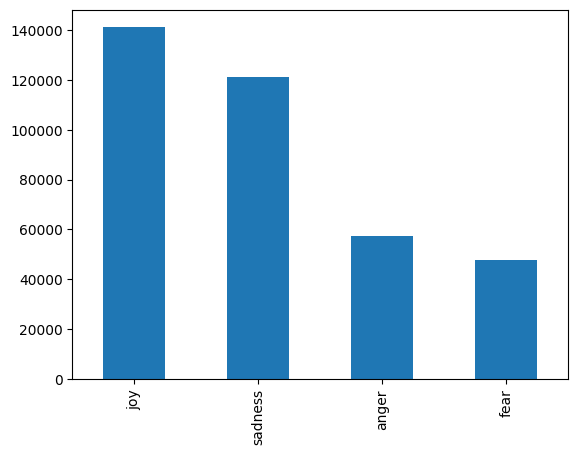

In [155]:
# Plot label histogram
dataset.emotions.value_counts().plot.bar()

In [48]:
# Prin some samples
dataset.head(10)

,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love
5,18231,i find myself frustrated with christians becau...,love
6,10714,i am one of those people who feels like going ...,joy
7,35177,i feel especially pleased about this as this h...,joy
8,122177,i was struggling with these awful feelings and...,joy
9,26723,i feel so enraged but helpless at the same time,anger


In [0]:
#for time issues we have trained our model on half data 

In [0]:
dataset=dataset[:150000]

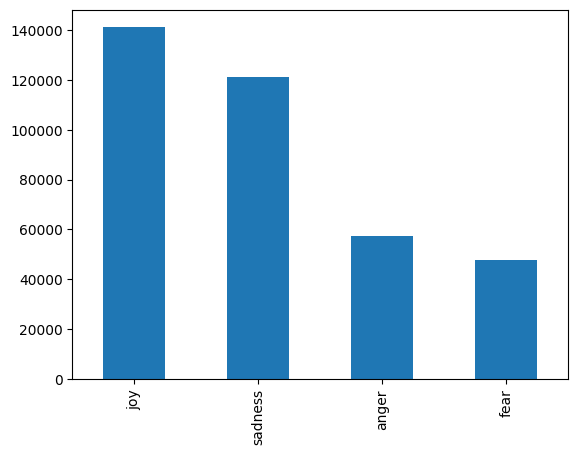

In [157]:
dataset.emotions.value_counts().plot.bar()

## Preparing data for model training
### Tokenization
Since the data is already tokenized and lowercased, we just need to split the words


In [0]:
input_sentences = [text.split(" ") for text in dataset["text"].values.tolist()]
labels = dataset["emotions"].values.tolist()

### Creating Vocabulary (word index)

In [56]:
# Initialize word2id and label2id dictionaries that will be used to encode words and labels
word2id = dict()
label2id = dict()

max_words = 0 # maximum number of words in a sentence

# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence:
        # Add words to word2id dict if not exist
        if word not in word2id:
            word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)
    
# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'joy', 1: 'anger', 2: 'fear', 3: 'sadness'}

### Encoding samples with corresponing integer values

In [57]:
import keras

# Encode input words and labels
X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]

# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')

# Print shapes
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))


Shape of X: (150000, 101)
Shape of Y: (150000, 4)


## Build LSTM model with attention 

In [58]:
embedding_dim = 100 # The dimension of word embeddings

# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')

# Word embedding layer
embedded_inputs =keras.layers.Embedding(len(word2id) + 1,
                                        embedding_dim,
                                        input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

# Attention Mechanism - Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()





Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 101)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 101, 100)     4600600     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 101, 100)     0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 101, 200)     160800      dropout_5[0][0]                  
____________________________________________________________________________________________

## Training the model

In [59]:
# Train model 10 iterations
model.fit(X, Y, epochs=2, batch_size=64, validation_split=0.1, shuffle=True)

Train on 135000 samples, validate on 15000 samples
Epoch 1/2
135000/135000 [==============================] - 983s 7ms/step - loss: 0.2467 - acc: 0.8937 - val_loss: 0.0498 - val_acc: 0.9730
Epoch 2/2
135000/135000 [==============================] - 974s 7ms/step - loss: 0.0478 - acc: 0.9746 - val_loss: 0.0458 - val_acc: 0.9747


In [0]:
model.save('my_model.h5')

The accuracy on validation data about 97%. Very good result for a classification task with six-classes.
The performance can be further improved by training the model a few more iteration.

#loading all needed files to do prediction on site we

In [0]:
import json

with open('id2label.json', 'w') as fp:
    json.dump(id2label,fp)

with open('label2id.json', 'w') as fp:
    json.dump(label2id,fp)


with open('word2id.json', 'w') as fp:
    json.dump(word2id,fp)


Example

In [0]:
def predict(text):
  import keras 
  from keras.models import load_model
  #loading model 
  my_model = load_model('/content/my_model.h5')
  #loading necessary dictionaries 
  with open('label2id.json', 'r') as fp:
    label2id = json.load(fp)
  with open('word2id.json', 'r') as fp:
    word2id = json.load(fp)
  # Encode samples
  tokenized_sample = text.split(" ")
  encoded_samples = []
  for word in tokenized_sample:
    if word2id.get(word,-1) != -1:
      encoded_samples.append(word2id.get(word))
  encoded_samples = [encoded_samples]

  # Padding
  encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=101)

  # Make predictions
  label_probs= my_model.predict(encoded_samples)
  label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

  return(label_probs)

In [159]:
predict('i had a nice day with my lovely friends')

{'joy': 0.39470324, 'anger': 0.2786284, 'fear': 0.031222545, 'sadness': 0.29544583}
